## MA 544 Spring 2021: Programming Assignment - 4
---


In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as pt
from typing import Iterable, List

### Question 1
---
Find the nonnegative basis representation of images from one of the following databases. Show a comparison of some sample images with their reconstruction from the basis.

>- The ORL database of faces at [ORL link](http://cam-orl.co.uk/facedatabase.html/#:~:text=Our%20Database%20of%20Faces%2C%20%28formerly%20%27The%20ORL%20Database,Robotics%20Group%20of%20the%20Cambridge%20University%20Engineering%20Department.).

>- The CBCL database of faces at [MIT link](http://cbcl.mit.edu/software-datasets/heisele/facerecognition-database.html).

>- Yale faces B facial images at [UCSD](http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html).

In [2]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [3]:
# to avoid having to write code to fully parse the data by subject I 
# will write it to handle a single subject, yaleB01
data_folder: str = os.path.join('data', 'CroppedYale', 'yaleB01')

In [4]:
class PGMReader():
    def __init__(self, filepath, mode):
        assert filepath.split('.')[-1] == 'pgm'
        self.filepath = filepath
        self.mode = mode
        
    def __enter__(self):
        # return the file object after opening and setting it up
        self.pgm_image = open(self.filepath, self.mode)
        return self.read_pgm(self.pgm_image)
    
    def __exit__(self, type, value, traceback):
        self.pgm_image.close()
    
    def read_pgm(self, pgmf):
        """Return a raster of integers from a PGM as a list of lists."""
        assert pgmf.readline() == b'P5\n'
        (width, height) = [int(i) for i in pgmf.readline().split()]
        depth = int(pgmf.readline())
        assert depth <= 255

        raster = []
        for y in range(height):
            row = []
            for y in range(width):
                row.append(ord(pgmf.read(1)))
            raster.append(row)
        return np.array(raster)

Shape of images: (192, 168)


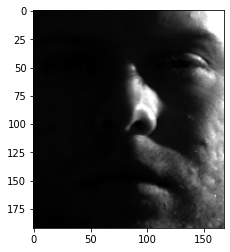

In [5]:
m, n = 192, 168
filepaths = list_files(data_folder, '*.pgm')
images = np.zeros((m*n, len(filepaths)))
for i, filepath in enumerate(filepaths):
    with PGMReader(filepath, 'rb') as image:
        images[:, i] = image.reshape((m*n,))
        
print(f"Shape of images: ({m}, {n})")
pt.imshow(images[:, 2].reshape((m, n)), cmap='gray')

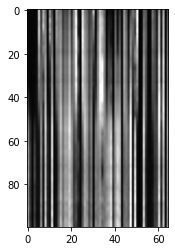

In [6]:
pt.imshow(images[:100, :], cmap='gray')

In [7]:
class LSNMF():
    def __init__(self, M):
        self.m, self.n = M.shape
        self.M = M
    
    def fit(self, threshold = 5e3, max_iter = 200):
        # initialize a random start state for W and H
        W = np.random.rand(self.m, self.n)
        H = np.random.rand(self.n, self.n)
        
        # @ delineates matrix multiplication
        # np.multiply delineates elementwise mutliplication
        # np.divide delineates elementwise division
        for i in range(max_iter):
            norm = np.linalg.norm(self.M - W @ H)
            if i % 50 == 0 or i == max_iter:
                print(f'Norm for iteration {i}: {norm}')
            if norm < threshold:
                print("Reached convergence through threshold")
                break
                
            wktv = np.dot(W.T, self.M)
            wktwk = np.dot(W.T, W)
            wktwkhk = np.dot(wktwk, H)
            
            H_kp1 = np.multiply(H, np.divide(wktv, wktwkhk))
            
            vhkp1t = np.dot(self.M, H_kp1.T)
            wkhkp1 = np.dot(W, H_kp1)
            wkhkp1hkp1t = np.dot(wkhkp1, H_kp1.T)
            
            W_kp1 = np.multiply(W, np.divide(vhkp1t, wkhkp1hkp1t))
            
            H = H_kp1
            W = W_kp1
            
            if i == max_iter-1:
                print("Reached convergence through max_iter")
        
        return W, H

In [8]:
lsnmf = LSNMF(images)

In [9]:
W, H = lsnmf.fit()

Norm for iteration 0: 123871.53692533601
Norm for iteration 50: 14007.521071852227
Norm for iteration 100: 10615.854694153719
Norm for iteration 150: 8693.851355028339
Reached convergence through max_iter


### Original Image

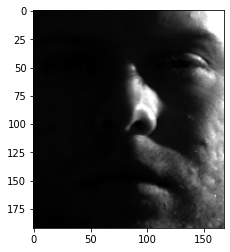

In [10]:
# original image 2
pt.imshow(images[:, 2].reshape(m, n), cmap='gray')

### NMF Reconstruction using the Lee-Seung Algorithm

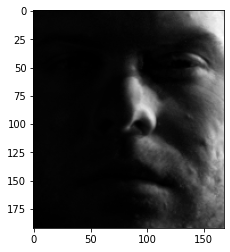

In [11]:
combinations = H[:, 2]
reconstruction = W @ combinations
pt.imshow(reconstruction.reshape(m, n), cmap='gray')

### Question 2
---
Set up a linear regression model for the miles per gallon on the data at automobile [UCI](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/).  Discard the categorical data.

>1. Analyze the data to get relevant insight.
>1. Get feature matrix X, and target variable y.
>1. Split data into training and testing.
>1. Normalize data using MinMaxScaler.
>1. Creat a LinearRegression object for modeling.
>1. Train the model with training data.
>1. Look at R^2 score for the goodness of fit for the train and test data.
>1. Present a graphical comparison of true and observed responses for the test data.
>1. Improve the performance of your model on the test data.

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [13]:
data_folder: str = os.path.join('data')

In [14]:
data = pd.read_csv(os.path.join(data_folder,'auto-mpg.data'),
                                 delim_whitespace=True,
                                 header=None)
column_names = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]
data.columns = column_names
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.00,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.00,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.00,2625.0,18.6,82,1,ford ranger


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [16]:
data.describe()

,mpg,cylinders,displacement,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [17]:
def is_float(x):
    try:
        float(x)
    except ValueError:
        return False
    return True

In [18]:
data = data[data['horsepower'].apply(lambda x: is_float(x))]

In [19]:
names = data.pop('car_name')
print(data.head())
data = data.astype(np.float)
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)
y = data[:, 0]
X = data[:, 1:]

    mpg  cylinders  displacement horsepower  weight  acceleration  model_year  \
0  18.0          8         307.0      130.0  3504.0          12.0          70   
1  15.0          8         350.0      165.0  3693.0          11.5          70   
2  18.0          8         318.0      150.0  3436.0          11.0          70   
3  16.0          8         304.0      150.0  3433.0          12.0          70   
4  17.0          8         302.0      140.0  3449.0          10.5          70   

   origin  
0       1  
1       1  
2       1  
3       1  
4       1  


In [20]:
class LinearRegression():
    def __init__(self, validation_split: float = 0.2, reg: str = 'l2', lam: float = 1e-2):
        assert 0. <= validation_split <= 1.
        assert reg in ['none', 'l2']
        if reg != 'none': 
            assert lam is not None
        self.reg = reg
        self.lam = lam
        self.validation_split = validation_split
        
    def fit(self, x_in, y_in):
        x_in = np.asarray(x_in)
        y_in = np.asarray(y_in)
        X, x_test, y, y_test = train_test_split(x_in, y_in, test_size=self.validation_split)
        
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        if self.reg == 'none':
            self.coef_ = np.linalg.inv(X.T @ X) @ np.dot(X.T, y) 
        if self.reg == 'l2':
            self.coef_ = np.linalg.inv(X.T @ X + self.lam*np.eye(X.shape[1])) @ np.dot(X.T, y)

        self.score_(x_test, y_test)
    
    def predict(self, features):
        features = np.hstack([features, np.array([1])])
        return np.dot(self.coef_, features)
    
    def score_(self, x_test, y_test):
        y_pred = []
        for x in x_test:
            y_pred.append(self.predict(x))
            
        self.r2 = np.corrcoef(y_test, y_pred)[0, 1]**2

In [21]:
linreg = LinearRegression(validation_split=0.1, reg='none')

In [22]:
linreg.fit(X, y)

### Results

In [23]:
print(f"Calculated Coefficients [C0, C1, ..., Cn] (C0 = intercept):\n {linreg.coef_}")

Calculated Coefficients [C0, C1, ..., Cn] (C0 = intercept):
 [-0.0442424   0.14197519 -0.02332282 -0.61780592  0.06323224  0.23843948
  0.06642967  0.43917258]


In [24]:
print(f"Calculated r2 on the test set: {linreg.r2}")

Calculated r2 on the test set: 0.8279471018412106


## Below, our predictions v true values are shown

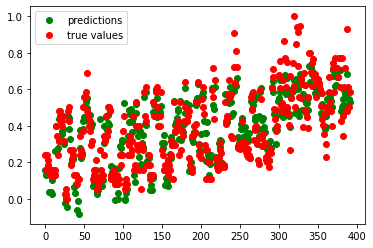

In [25]:
predictions = []
for x in X:
    predictions.append(linreg.predict(np.hstack(x)))
pt.plot(range(len(X)), predictions, 'go')
pt.plot(range(len(X)), y, 'ro')

pt.legend(["predictions", "true values"])
pt.show()

## Custom linear regression vs sklearn benchmark

In [26]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1, fit_intercept=True)
model.fit(X, y)
print(f"Calculated Coefficients:\n {model.coef_}")

Calculated Coefficients:
 [-0.05512088  0.03582705 -0.1124368  -0.42336983 -0.00825621  0.2262201
  0.07311041]


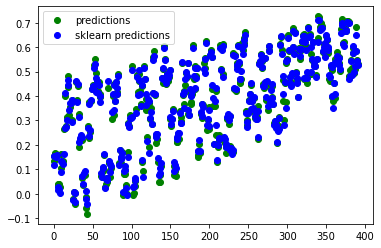

In [27]:
bench = []
for row in X:
    bench.append(model.predict(row.reshape(1, -1)))
pt.plot(range(len(X)), predictions, 'go')
pt.plot(range(len(X)), bench, 'bo')
pt.legend(["predictions", "sklearn predictions"])
pt.show()

## Improve through adding regularization

In [28]:
linreg2 = LinearRegression(validation_split=0.1, reg='l2', lam=1.)

In [29]:
linreg2.fit(X, y)

In [30]:
print(f"Calculated Coefficients [C0, C1, ..., Cn] (C0 = intercept):\n {linreg2.coef_}")

Calculated Coefficients [C0, C1, ..., Cn] (C0 = intercept):
 [-0.0488963   0.03359471 -0.05863788 -0.42248748  0.05375112  0.23727411
  0.08471192  0.41158973]


In [31]:
print(f"Calculated r2 on the test set: {linreg2.r2}")

Calculated r2 on the test set: 0.8300385504557488


## Below, our predictions v true values are shown

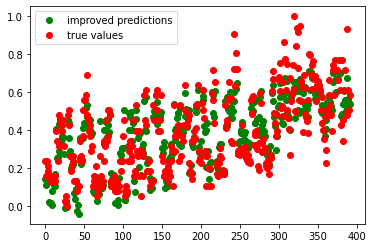

In [32]:
predictions2 = []
for x in X:
    predictions2.append(linreg2.predict(np.hstack(x)))
pt.plot(range(len(X)), predictions2, 'go')
pt.plot(range(len(X)), y, 'ro')

pt.legend(["improved predictions", "true values"])
pt.show()

## Custom linear regression vs sklearn benchmark

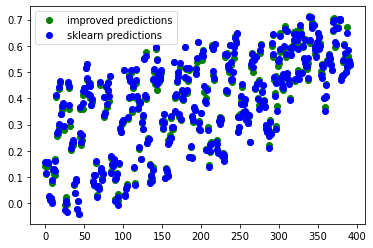

In [33]:
y_pred2 = []
pt.plot(range(len(X)), predictions2, 'go')
pt.plot(range(len(X)), bench, 'bo')
pt.legend(["improved predictions", "sklearn predictions"])
pt.show()

### Question 3
---
Setup a logistic regression model on the data at [adultUCI](http://archive.ics.uci.edu/ml/datasets/Adult).  Discuss the performance of your model using appropriate statistics. Use dummy variables to handle categorical variables. 

>1. Prepare the data. Create dummy variables for categorical variables. [See this](https://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example)
>1. Analyze the data to get relevant insight.
>2. Get feature matrix X, and target variable y (>50k or <50k)
>3. Split data into training and testing
>4. Normalize data using MinMaxScaler
>5. Creat a LogisticRegression object for modeling
>6. Train the model with training data
>7. Compare the precision, recall, and F1-score on the train and test data.
>1. Improve the performance of your model on the test data.

## As an interesting thought experiment, a logistic regression can be thought of as a dense network with num_features input nodes, num_classes output nodes, and a sigmoid activation. I will build this network using the Tensorflow API

In [34]:
data = pd.read_csv(os.path.join(data_folder, 'adult.data'), header=None)
orig_cols = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'target']
data.columns = orig_cols
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [35]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

In [36]:
data = pd.concat([data, pd.get_dummies(data["workclass"], prefix="wc")], axis=1)
data = pd.concat([data, pd.get_dummies(data["education"], prefix="edu")], axis=1)
data = pd.concat([data, pd.get_dummies(data["marital_status"], prefix="ms")], axis=1)
data = pd.concat([data, pd.get_dummies(data["occupation"], prefix="occ")], axis=1)
data = pd.concat([data, pd.get_dummies(data["relationship"], prefix="rel")], axis=1)
data = pd.concat([data, pd.get_dummies(data["race"], prefix="rac")], axis=1)
data = pd.concat([data, pd.get_dummies(data["sex"], prefix="s")], axis=1)
data = pd.concat([data, pd.get_dummies(data["native_country"], prefix="s")], axis=1)

data.target = data.target.astype('category')
data.target = data.target.cat.codes

for colname in ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]:
    data.drop([colname], axis=1, inplace=True)

In [37]:
data.head(1)

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,target,wc_ ?,wc_ Federal-gov,wc_ Local-gov,...,s_ Portugal,s_ Puerto-Rico,s_ Scotland,s_ South,s_ Taiwan,s_ Thailand,s_ Trinadad&Tobago,s_ United-States,s_ Vietnam,s_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [38]:
y = data.pop('target').values
X = data.values

In [39]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
class LogisticRegression(tf.keras.Model):
    def __init__(self, num_features: int = None, reg = None):
        assert num_features is not None and num_features >= 1 and isinstance(num_features, int)
        assert len(reg) == 2 and 0. <= reg[0] and 0. <= reg[1]
        
        super(LogisticRegression, self).__init__()
        self.inp = Input((num_features,))
        self.outputs = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1L2(l1=reg[0], l2=reg[1]))
    
    def call(self, features):
        return self.outputs(features)

In [42]:
logistic = LogisticRegression(num_features=X.shape[1], reg = [0.001, 0.001])
logistic.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=[tf.keras.metrics.Precision(), 
                          tf.keras.metrics.Recall(), 
                          tf.keras.metrics.TruePositives(), 
                          tf.keras.metrics.TrueNegatives(), 
                          tf.keras.metrics.FalsePositives(), 
                          tf.keras.metrics.FalseNegatives(), 
                          tf.keras.metrics.AUC()])

print(f'random output for initialization = {logistic(X[0, :].reshape(1, -1))}')

random output for initialization = [[0.5663379]]


In [43]:
logistic.summary()

Model: "logistic_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  109       
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = logistic.fit(x_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
814/814 [==============================] - 3s 2ms/step - loss: 0.5309 - precision: 0.4037 - recall: 0.0424 - true_positives: 204.8000 - true_negatives: 9773.6687 - false_positives: 122.7840 - false_negatives: 2954.7080 - auc: 0.7084
Epoch 2/5
814/814 [==============================] - 2s 2ms/step - loss: 0.4146 - precision: 0.7195 - recall: 0.4244 - true_positives: 1387.7436 - true_negatives: 9370.1387 - false_positives: 535.5080 - false_negatives: 1762.5706 - auc: 0.8609
Epoch 3/5
814/814 [==============================] - 2s 3ms/step - loss: 0.4042 - precision: 0.7106 - recall: 0.4701 - true_positives: 1488.4724 - true_negatives: 9309.8626 - false_positives: 612.4025 - false_negatives: 1645.2233 - auc: 0.8674
Epoch 4/5
814/814 [==============================] - 2s 3ms/step - loss: 0.3998 - precision: 0.7184 - recall: 0.4791 - true_positives: 1520.5325 - true_negatives: 9311.4687 - false_positives: 605.6209 - false_negatives: 1618.3387 - auc: 0.8747
Epoch 5/5
814/814 [======

In [45]:
history.history.keys()

dict_keys(['loss', 'precision', 'recall', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'auc'])

In [46]:
precision = history.history['precision'][-1]
recall = history.history['recall'][-1]
tp = history.history['true_positives'][-1]
tn = history.history['true_negatives'][-1]
fp = history.history['false_positives'][-1]
fn = history.history['false_negatives'][-1]
auc = history.history['auc'][-1]

In [47]:
f1 = 2*precision*recall / (precision+recall)

## Training stats

In [48]:
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1 score: {f1}')
print(f'true pos: {tp}')
print(f'true neg: {tn}')
print(f'false pos: {fp}')
print(f'false neg: {fn}')
print(f'auc: {auc}')

precision: 0.7135922312736511
recall: 0.4946322739124298
f1 score: 0.5842717913534946
true pos: 3087.0
true neg: 18568.0
false pos: 1239.0
false neg: 3154.0
auc: 0.8746693134307861


## Test stats

In [49]:
results = logistic.evaluate(x_test, y_test, batch_size=32)

204/204 [==============================] - 1s 3ms/step - loss: 0.4024 - precision: 0.7297 - recall: 0.4706 - true_positives: 753.0000 - true_negatives: 4634.0000 - false_positives: 279.0000 - false_negatives: 847.0000 - auc: 0.8768


In [50]:
testf1 = 2 * results[1] * results[2] / (results[1] + results[2])
print(f'test f1 score: {testf1}')

test f1 score: 0.572188456556238


## Improve through tuning elasticnet regularization

In [51]:
logistic_reg = LogisticRegression(num_features=X.shape[1], reg = [0.0001, 0.0001])
logistic_reg.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=[tf.keras.metrics.Precision(), 
                          tf.keras.metrics.Recall(), 
                          tf.keras.metrics.TruePositives(), 
                          tf.keras.metrics.TrueNegatives(), 
                          tf.keras.metrics.FalsePositives(), 
                          tf.keras.metrics.FalseNegatives(), 
                          tf.keras.metrics.AUC()])

print(f'random output for initialization = {logistic_reg(X[0, :].reshape(1, -1))}')

random output for initialization = [[0.7327791]]


In [52]:
logistic_reg.summary()

Model: "logistic_regression_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  109       
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [53]:
history_reg = logistic_reg.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
814/814 [==============================] - 3s 3ms/step - loss: 0.5841 - precision_1: 0.2359 - recall_1: 0.1310 - true_positives_1: 317.2037 - true_negatives_1: 9010.2196 - false_positives_1: 888.7239 - false_negatives_1: 2839.8135 - auc_1: 0.5842
Epoch 2/5
814/814 [==============================] - 2s 3ms/step - loss: 0.3930 - precision_1: 0.7391 - recall_1: 0.3966 - true_positives_1: 1311.0466 - true_negatives_1: 9454.6675 - false_positives_1: 468.6270 - false_negatives_1: 1821.6196 - auc_1: 0.8623
Epoch 3/5
814/814 [==============================] - 2s 3ms/step - loss: 0.3678 - precision_1: 0.7226 - recall_1: 0.5007 - true_positives_1: 1572.9325 - true_negatives_1: 9294.2712 - false_positives_1: 624.6638 - false_negatives_1: 1564.0933 - auc_1: 0.8786
Epoch 4/5
814/814 [==============================] - 2s 3ms/step - loss: 0.3641 - precision_1: 0.7059 - recall_1: 0.5158 - true_positives_1: 1636.0969 - true_negatives_1: 9254.2957 - false_positives_1: 662.8209 - false_negative

In [54]:
history_reg.history.keys()

dict_keys(['loss', 'precision_1', 'recall_1', 'true_positives_1', 'true_negatives_1', 'false_positives_1', 'false_negatives_1', 'auc_1'])

In [55]:
precision = history_reg.history['precision_1'][-1]
recall = history_reg.history['recall_1'][-1]
tp = history_reg.history['true_positives_1'][-1]
tn = history_reg.history['true_negatives_1'][-1]
fp = history_reg.history['false_positives_1'][-1]
fn = history_reg.history['false_negatives_1'][-1]
auc = history_reg.history['auc_1'][-1]

## Improved training stats

In [56]:
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1 score: {f1}')
print(f'true pos: {tp}')
print(f'true neg: {tn}')
print(f'false pos: {fp}')
print(f'false neg: {fn}')
print(f'auc: {auc}')

precision: 0.7128393054008484
recall: 0.5302035212516785
f1 score: 0.5842717913534946
true pos: 3309.0
true neg: 18474.0
false pos: 1333.0
false neg: 2932.0
auc: 0.8847647309303284


## Improved test stats

In [57]:
results = logistic_reg.evaluate(x_test, y_test, batch_size=32)

204/204 [==============================] - 1s 2ms/step - loss: 0.3588 - precision_1: 0.7210 - recall_1: 0.5331 - true_positives_1: 853.0000 - true_negatives_1: 4583.0000 - false_positives_1: 330.0000 - false_negatives_1: 747.0000 - auc_1: 0.8876


In [58]:
testf1 = 2 * results[1] * results[2] / (results[1] + results[2])
print(f'test f1 score: {testf1}')

test f1 score: 0.6130075325051406
